In [2]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.12.1


In [3]:
# Imports
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Carregando os dados
train = pd.read_csv('train.csv')
x_test = pd.read_csv('test.csv')


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [7]:
train.isnull().values.any()

False

In [8]:
# Verificando valores nulos
x_test.isnull().values.any()

False

In [9]:
# Separando features e target
x = train.drop(columns=['ID','TARGET'],axis=1)
y = train['TARGET']

In [10]:
# Retirando a coluna ID
x_test = x_test.drop(columns=['ID'], axis=1)

In [11]:
#Padronização
sc = StandardScaler()
x = sc.fit_transform(x)
x_test_normalized = sc.transform(x_test)

In [12]:
# Removendo variaveis constantes usando VarianceThreshold
constant_filter = VarianceThreshold(threshold=0.01)
x_filtered = constant_filter.fit_transform(x)
x_test_filtered = constant_filter.transform(x_test_normalized)

In [13]:
x = x_filtered
x_test = x_test_filtered

In [14]:
# Split em dados de treino e teste com amostragem estratificada
X_treino,X_val,y_treino,y_val = train_test_split(x,
                                                     y,
                                                     test_size=0.25,
                                                     random_state=1234)

In [15]:
X_treino.shape,X_val.shape,y_treino.shape,y_val.shape

((57015, 335), (19005, 335), (57015,), (19005,))

## Balanceamento de Classe

In [16]:
y_treino.value_counts()

TARGET
0    54749
1     2266
Name: count, dtype: int64

In [17]:
# Carregar a função SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

In [18]:
# Vamos aplicar a técnica de oversampling e aumentar o número de exemplos da classe minoritária
sm = SMOTE(k_neighbors=2)

In [19]:
X_res,y_res = sm.fit_resample(X_treino,y_treino)

In [20]:
y_res.value_counts()

TARGET
0    54749
1    54749
Name: count, dtype: int64

In [21]:
# Ajustando o nome dos datasets de treino
X_treino = X_res
y_treino = y_res

## Modelo 1: Regressão Logística

In [22]:
# Lista de hiperparametros
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
                   'penalty': ['l1', 'l2']}

In [23]:
# GridSearch: criação de vários modelos com combinações diferentes de hiperparamentros
modelo_v1 = GridSearchCV(LogisticRegression(),
                         tuned_params_v1,
                         scoring='roc_auc',
                         n_jobs=-1)

In [24]:
# Treinamento do modelo
modelo_v1.fit(X_treino,y_treino)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [25]:
# Selecionando o melhor modelo
modelo_v1.best_estimator_

LogisticRegression(C=1)

In [26]:
# Previsão com dados de validação
y_pred_v1 = modelo_v1.predict(X_val)

In [27]:
# Matriz de confusão
cm=confusion_matrix(y_val,y_pred_v1)

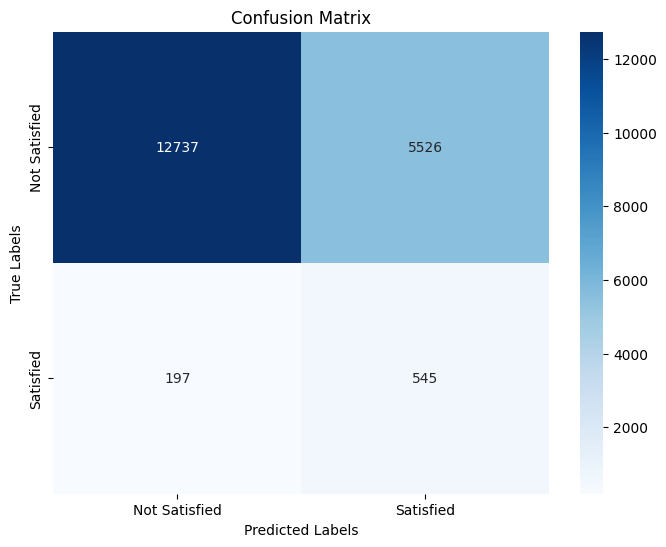

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

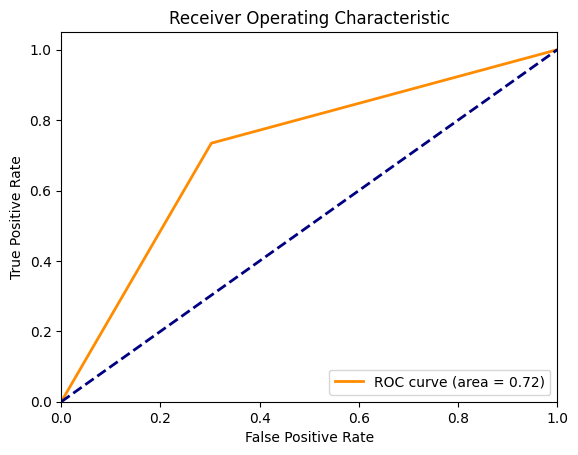

In [29]:
fpr, tpr, _ = roc_curve(y_val, y_pred_v1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Métrica AUC Score com dados reais e previsões em teste
roc_auc_v1 = roc_auc_score(y_val,y_pred_v1)
print(roc_auc_v1)

0.7159611814380866


In [31]:
# Acurácia em teste: Dentre todas as classificações, quantas o modelo classificou corretamente?
acuracia_v1 = accuracy_score(y_val,y_pred_v1)
print(acuracia_v1)

0.6988687187582215


In [32]:
# Dicionário com as métricas do modelo_v1
dict_modelo_v1 = {'Nome': 'Modelo_v1',
                  'Algoritmo': 'Regressão Logística',
                  'ROC_AUC Score' : roc_auc_v1,
                  'Acurácia' : acuracia_v1}

In [33]:
# Data frame com os resultados dos modelos
df_modelos = pd.DataFrame([dict_modelo_v1])


In [34]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,Acurácia
0,Modelo_v1,Regressão Logística,0.715961,0.698869


## Modelo 2: Random Forest

In [36]:
# Grid de Hiperparâmetros
tuned_params_v2 = {'n_estimators': [100,200,300,400,500],
                   'min_samples_split': [2,5,10],
                   'min_samples_leaf':[1,2,3]}

In [45]:
# Criando o modelo com RandomizedSearchCV 
modelo_v2 = RandomizedSearchCV(RandomForestClassifier(),
                               tuned_params_v2,
                               n_iter = 5,
                               scoring = 'roc_auc',
                               n_jobs = -1)

In [46]:
# Treinar o modelo
modelo_v2.fit(X_treino,y_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [47]:
# Extrai o melhor estimador
modelo_v2.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [48]:
# testando o modelo
y_pred_v2 = modelo_v2.predict(X_val)

In [49]:
# Matriz de confusão
confusion_matrix(y_val,y_pred_v2)

array([[17178,  1085],
       [  563,   179]], dtype=int64)

In [50]:
# Curva ROC
roc_auc_v2 = roc_auc_score(y_val, y_pred_v2)
print(roc_auc_v2)

0.5909150783262168


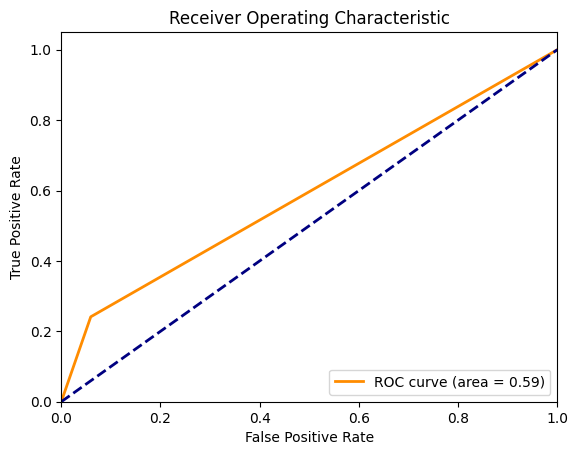

In [53]:
fpr, tpr, _ = roc_curve(y_val, y_pred_v2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Acurácia
acuracia_v2 = accuracy_score(y_val,y_pred_v2)
print(acuracia_v2)

0.9132859773743751


In [59]:
dict_modelo_v2 = {'Nome': 'Modelo_v2',
                  'Algoritmo': 'Random Forest',
                  'ROC_AUC Score' : roc_auc_v2,
                  'Acurácia' : acuracia_v2}

In [69]:
df_modelo_v2 = pd.DataFrame([dict_modelo_v2])
df_modelos = pd.concat([df_modelos,df_modelo_v2], ignore_index=True)

In [71]:
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,Acurácia
0,Modelo_v1,Regressão Logística,0.715961,0.698869
1,Modelo_v2,Random Forest,0.590915,0.913286


# Modelo 3: KNN

In [72]:
# Lista com possiveis valores de K
vizinhos = list(range(1,20,2))
# Lista com os scores
cv_scores = []

In [74]:
# Validação cruzada para determinar o melhor valor de k
for k in vizinhos:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_treino, y_treino, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

In [75]:
# Ajustando o erro do classificador
erro = [1 - x for x in cv_scores]

In [76]:
# Determinando o melhor valor de k (com menor erro)
optimal_k = vizinhos[erro.index(min(erro))]
print('O melhor valor de k é %d' % optimal_k)

O melhor valor de k é 1


In [77]:
# Criando o modelo 3
modelo_v3 = KNeighborsClassifier(n_neighbors = optimal_k)

In [78]:
# Treinando o modelo
modelo_v3.fit(X_treino,y_treino)

KNeighborsClassifier(n_neighbors=1)

In [80]:
# Previsões
y_pred_v3 = modelo_v3.predict(X_val)

In [81]:
# Confusion Matrix
confusion_matrix(y_val,y_pred_v3)

array([[16775,  1488],
       [  575,   167]], dtype=int64)

In [84]:
# ROC AUC
roc_auc_v3 = roc_auc_score(y_val,y_pred_v3)
print(roc_auc_v3)

0.5717955883583573


In [85]:
# Acurácia
acuracia_v3 = accuracy_score(y_val,y_pred_v3)
print(acuracia_v3)

0.8914496185214418


In [86]:
dict_modelo_v3 = {'Nome': 'Modelo_v3',
                  'Algoritmo': 'KNN',
                  'ROC_AUC Score' : roc_auc_v3,
                  'Acurácia' : acuracia_v3}

In [89]:
df_modelo_v3 = pd.DataFrame([dict_modelo_v3])
df_modelos = pd.concat([df_modelos, df_modelo_v3], ignore_index = True)
display(df_modelos)

,Nome,Algoritmo,ROC_AUC Score,Acurácia
0,Modelo_v1,Regressão Logística,0.715961,0.698869
1,Modelo_v2,Random Forest,0.590915,0.913286
2,Modelo_v3,KNN,0.571796,0.891450


# Modelo 4: SVM

In [94]:
# Função para seleção de hiperparâmentros
def svc_param_selection(X,y,nfolds):
    Cs = [0.001, 0.01, 1, 10]
    gammas = [0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(SVC(kernel = 'rbf'),param_grid, cv = nfolds)
    grid_search.fit(X_treino, y_treino)
    grid_search.best_params_
    return grid_search.best_params_

In [95]:
# Aplica a função
svc_param_selection(X_treino, y_treino,5)

In [ ]:
# Cria o modelo com os melhores hiperparâmentros
modelo_v4 = SVC